In [1]:
fileLocation= 'D:/aditya/Final Year/Project Work/Automated_NLP_Based_Data_Handler/datasets/Aditya/imageEvidence'

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import ndimage

In [350]:
imno=16

imno= 42

In [351]:
def read(file, gray_scale= False):
    img= cv.imread(file)
    if gray_scale:
        img= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    else:
        img= cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

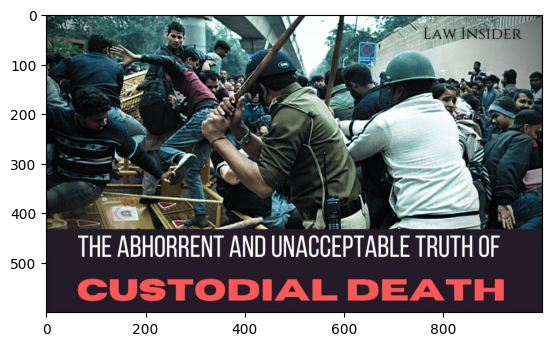

In [378]:
im= read(fileLocation+'/{}.jpg'.format(imno))
plt.imshow(im)

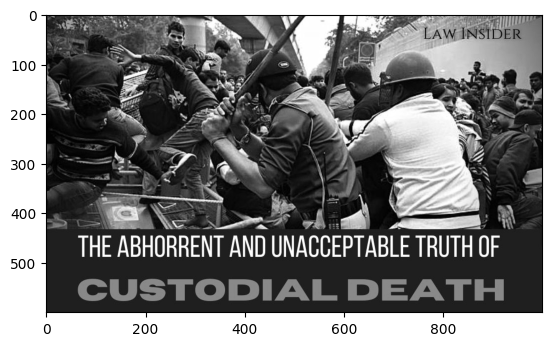

In [352]:
image= read(fileLocation+'/{}.jpg'.format(imno),True)
plt.imshow(image,cmap='gray')

In [353]:
def createGaborFilter():
    filters= []
    numFilters= 16
    ksize= 35
    sigma= 3.0
    lamda=10.0
    gamma= 0.5
    psi= 0
    for theta in np.arange(0,np.pi, np.pi/numFilters):
        kern= cv.getGaborKernel((ksize,ksize),sigma,theta,lamda,gamma,psi,ktype=cv.CV_64F)
        kern/=1.0*kern.sum()
        filters.append(kern)
    return filters

def applyFilter(img, filters):
    newimage= np.zeros_like(img)
    depth = -1
    for kern in filters:
        imageFilter= cv.filter2D(img,depth,kern)
        newimage= np.maximum(newimage,imageFilter)
    return newimage

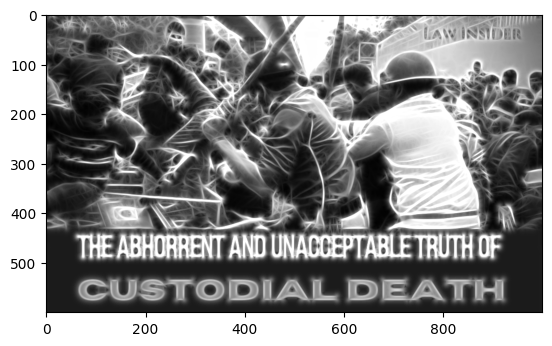

In [354]:
filter= createGaborFilter()
filteredImage= applyFilter(image,filter)
plt.imshow(filteredImage,cmap='gray')

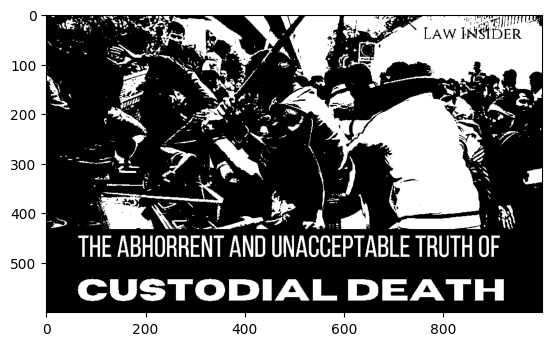

In [355]:
ret, thresh = cv.threshold(image, 120, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
plt.imshow(thresh,cmap='gray')

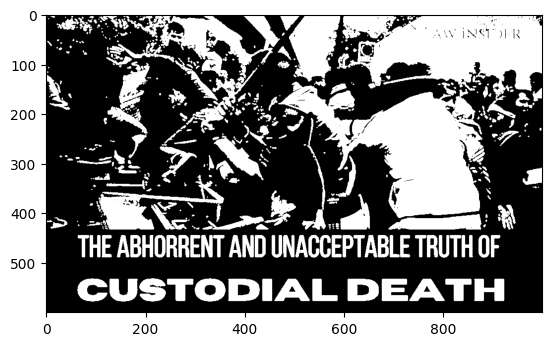

In [356]:
dilatedImage= ndimage.binary_dilation(thresh)
plt.imshow(dilatedImage,cmap='gray')

In [357]:
def binarize_image(file, threshold=127,with_plot=False,gray_scale=False):
    source= read(file, gray_scale) if isinstance(file, str) else cv.cvtColor(file,cv.COLOR_RGB2GRAY) if gray_scale else file
    thresh, binarized_image= cv.threshold(source, threshold, maxval= 255, type=cv.THRESH_BINARY)
    if with_plot:
        cmap= None if not gray_scale else 'gray'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,20))
        ax1.axis("off")
        ax1.title.set_text('Original')
        ax2.axis('off')
        ax2.title.set_text('Binarized')
        ax1.imshow(source, cmap='gray')
        ax2.imshow(binarized_image, cmap='gray')
    return binarized_image

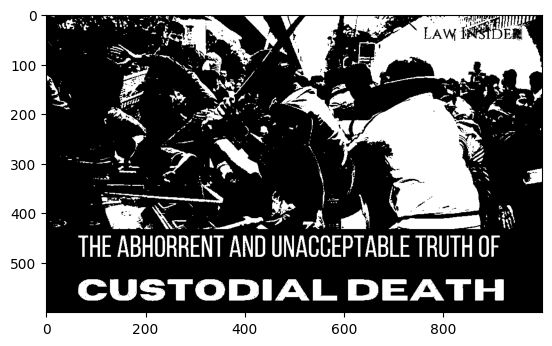

In [358]:
binaryImage= binarize_image(fileLocation+'/{}.jpg'.format(imno),gray_scale=True)
plt.imshow(binaryImage,cmap='gray')

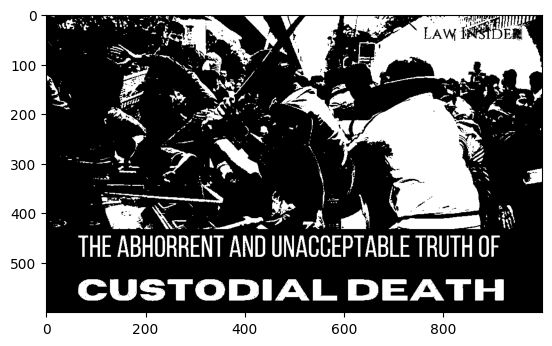

In [359]:
productImage= cv.multiply(src1=dilatedImage.astype(int), src2= binaryImage.astype(int))
plt.imshow(productImage,cmap='gray')

In [360]:
import imageio.v3 as iio
import skimage.color
import skimage.filters
import skimage.measure

def connected_components(filename, sigma=1.0, t=0.5, connectivity=1):
    # load the image
    image = iio.imread(filename) if isinstance(filename,str) else filename
    
    # convert the image to grayscale
    gray_image = skimage.color.rgb2gray(image) if isinstance(filename,str) else filename
    
    # denoise the image with a Gaussian filter
    blurred_image = skimage.filters.gaussian(gray_image, sigma=sigma) if isinstance(filename,str) else filename
    plt.imshow(blurred_image,cmap='gray')
    # mask the image according to threshold
    binary_mask = blurred_image < t
    # perform connected component analysis
    labeled_image, count = skimage.measure.label(binary_mask,
                                                 connectivity=connectivity, return_num=True)
    return labeled_image, count

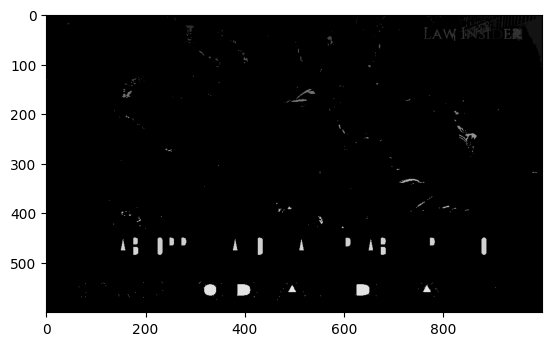

In [361]:
img, count= connected_components(productImage)
plt.imshow(img,cmap='gray')

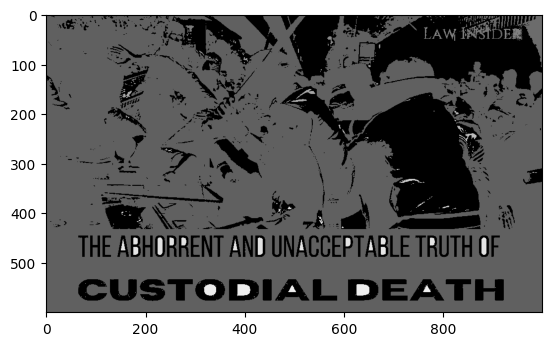

In [362]:
newImage= cv.subtract(img,productImage)
plt.imshow(newImage,cmap='gray')

Uncanny Edge Detection

In [363]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

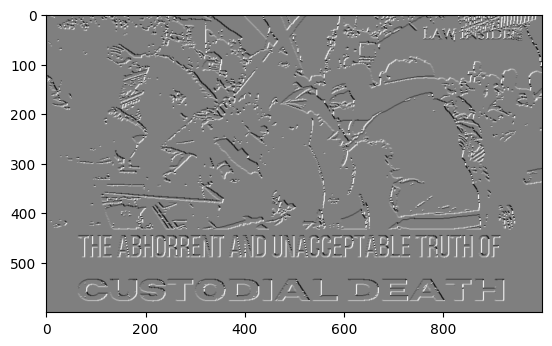

In [364]:
filteredImage, angle= sobel_filters(newImage)
plt.imshow(angle,cmap='gray')

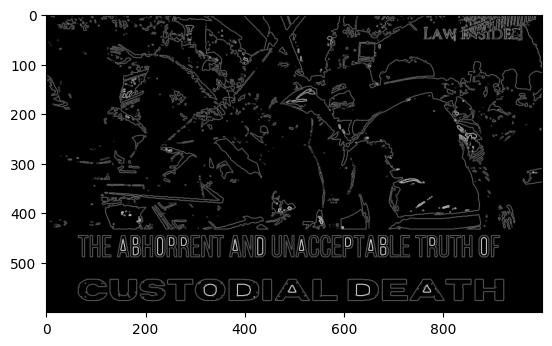

In [365]:
plt.imshow(filteredImage,cmap='gray')

In [366]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

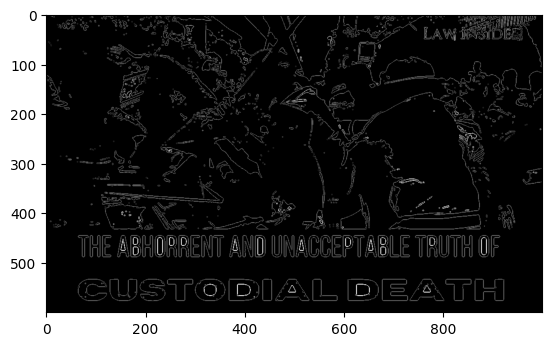

In [367]:
supressedImage= non_max_suppression(filteredImage,angle)
plt.imshow(supressedImage,cmap='gray')

In [368]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

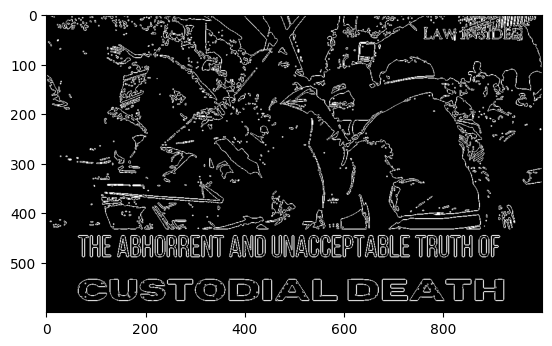

In [369]:
thresholdedImage, strong, weak= threshold(supressedImage)
plt.imshow(thresholdedImage,cmap='gray')

In [370]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

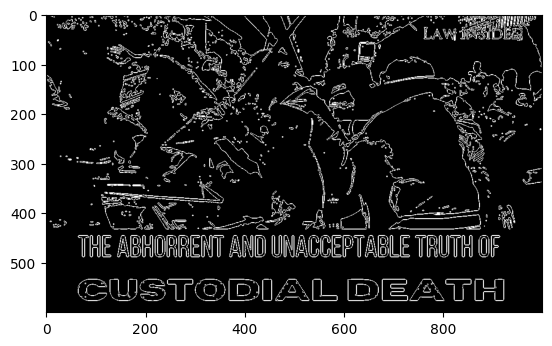

In [371]:
lastImage= hysteresis(thresholdedImage,weak)
plt.imshow(lastImage,cmap='gray')

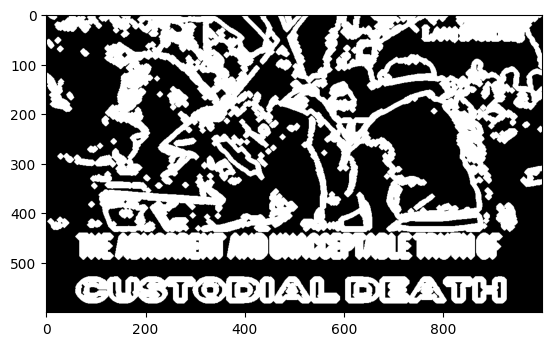

In [372]:
dilatedImage= ndimage.binary_dilation(lastImage,iterations=5)
plt.imshow(dilatedImage,cmap='gray')

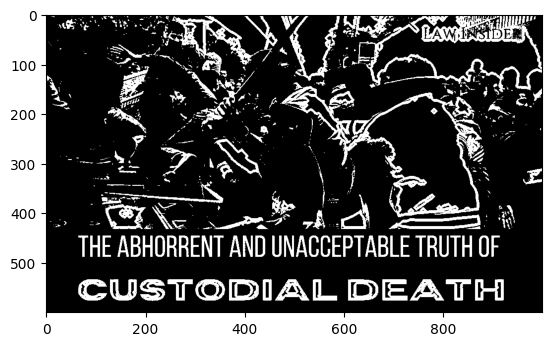

In [373]:
textImage= cv.multiply(dilatedImage.astype(int),binaryImage.astype(int))
plt.imshow(textImage,cmap='gray')

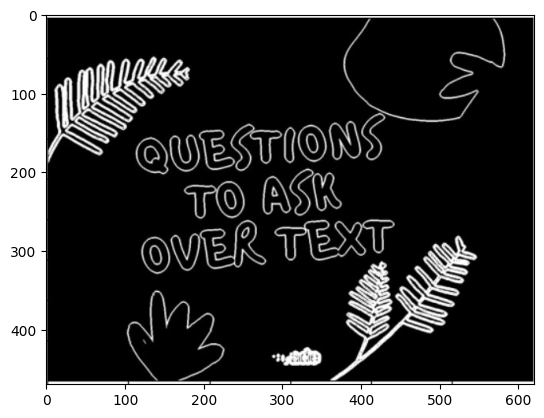

In [374]:
img1= read('../../data/sos19.jpg')
plt.imshow(img1)

In [375]:
from pytesseract import pytesseract
pathToTesseract= r'C:\Program Files\Tesseract-OCR\tesseract.exe'
pytesseract.tesseract_cmd= pathToTesseract

In [376]:
text = pytesseract.image_to_string(image=img1)
text

''